# Test object accuracy
## 1. Visualize object bbox in the images
## 2. Output classifier logits of each object

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision

from tqdm import tqdm
import numpy
import matplotlib.pyplot as plt


In [2]:
# from train_app import get_dataset
from data.cocostuff_loader import CocoSceneGraphDataset

from model.resnet_generator_v2 import ResnetGenerator128
from model.rcnn_discriminator_app import CombineDiscriminator128_app

img_size = 128
z_dim = 128
lamb_obj = 1.0
lamb_app = 1.0
lamb_img = 0.1
num_classes = 184
num_obj = 8
dataset = "coco"
batch_size = 16

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

def get_dataset(dataset, img_size):
    if dataset == "coco":
        data = CocoSceneGraphDataset(image_dir='./datasets/coco/val2017/',
                                     instances_json='./datasets/coco/annotations/instances_val2017.json',
                                     stuff_json='./datasets/coco/annotations/stuff_val2017.json',
                                    #  max_samples=4096,
                                     stuff_only=True, image_size=(img_size, img_size), left_right_flip=Fa)
    elif dataset == 'vg':
        data = VgSceneGraphDataset(vocab_json='./data/tmp/vocab.json', h5_path='./data/tmp/preprocess_vg/train.h5',
                                   image_dir='./datasets/vg/',
                                   image_size=(img_size, img_size), max_objects=30, left_right_flip=True)
    return data


# data loader
train_data = get_dataset(dataset, img_size)
print(f"{dataset.title()} datasets with {len(train_data)} samples has been created!")

num_gpus = torch.cuda.device_count()
num_workers = 20
if num_gpus > 1:
    parallel = True
    args.batch_size = batch_size * num_gpus
    num_workers = num_workers * num_gpus
else:
    parallel = False

print("{} GPUs, {} workers are used".format(num_gpus, num_workers))
dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    drop_last=True, shuffle=False, num_workers=num_workers)

# Load model
device = torch.device('cuda')
netG = ResnetGenerator128(num_classes=num_classes, output_dim=3).to(device)
# netD = CombineDiscriminator128_app(num_classes=num_classes).to(device)

called set_image_size (128, 128)
Coco datasets with 6194 samples has been created!
1 GPUs, 20 workers are used


In [3]:
# Load ckpts
import os
from collections import OrderedDict


ckpt_G_dir = "outputs/app/model/G_155.pth"
ckpt_D_dir = "outputs/app/model/D_155.pth"
if not os.path.isfile(ckpt_D_dir) or not os.path.isfile(ckpt_D_dir):
    print("Invalid file path")

state_dict = torch.load(ckpt_G_dir, map_location="cuda:0")
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`nvidia
    new_state_dict[name] = v

model_dict = netG.state_dict()
pretrained_dict = {k: v for k,
                    v in new_state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
netG.load_state_dict(model_dict)


# state_dict = torch.load(ckpt_D_dir, map_location="cuda:0")
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     name = k[7:]  # remove `module.`nvidia
#     new_state_dict[name] = v

# model_dict = netD.state_dict()
# pretrained_dict = {k: v for k,
#                     v in new_state_dict.items() if k in model_dict}
# model_dict.update(pretrained_dict)
# netD.load_state_dict(model_dict)

# netD.eval(); # suppress output of model.
netG.eval();



In [4]:
## sample images
from torchvision.utils import make_grid

torch.cuda.empty_cache()
batch = next(iter(dataloader))
real_imgs, label, bbox = batch
# print(bbox[0][0])
real_imgs, label, bbox = real_imgs.to(device), label.long().to(device).unsqueeze(-1), bbox.float().to(device)

z = torch.randn(real_imgs.size(0), num_obj, z_dim).to(device)
fake_imgs = netG(z, bbox, y=label.squeeze(dim=-1))


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


tensor([[ 69,  46,  83,  95],
        [  0,   7, 128,  80],
        [  0,   0, 128,  54],
        [  0,  62, 128, 127],
        [  0,  66, 128, 111],
        [180, 180, 244, 244],
        [180, 180, 244, 244],
        [180, 180, 244, 244]], dtype=torch.uint8)


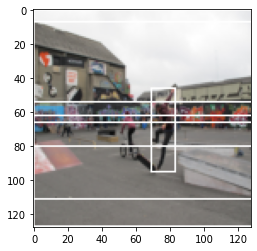

In [5]:
from utils.draw_bbox import draw_bounding_boxes
import json
from data.cocostuff_loader import imagenet_deprocess

# single case test
im = real_imgs[1].clone().detach().cpu()
bb = bbox[1].detach().cpu()
im = ((im*0.5+0.5)*255).to(torch.uint8)
bb = (bb*128).to(torch.uint8)
bb[:,2] += bb[:,0]
bb[:,3] += bb[:,1]
print(bb)
im_b = draw_bounding_boxes(im, bb)
plt.imshow(im_b.permute(1,2,0))

## 注意：这个版本的coco数据集返回的bbox格式是：x0,y0,w,h

## 1. visualize bbox

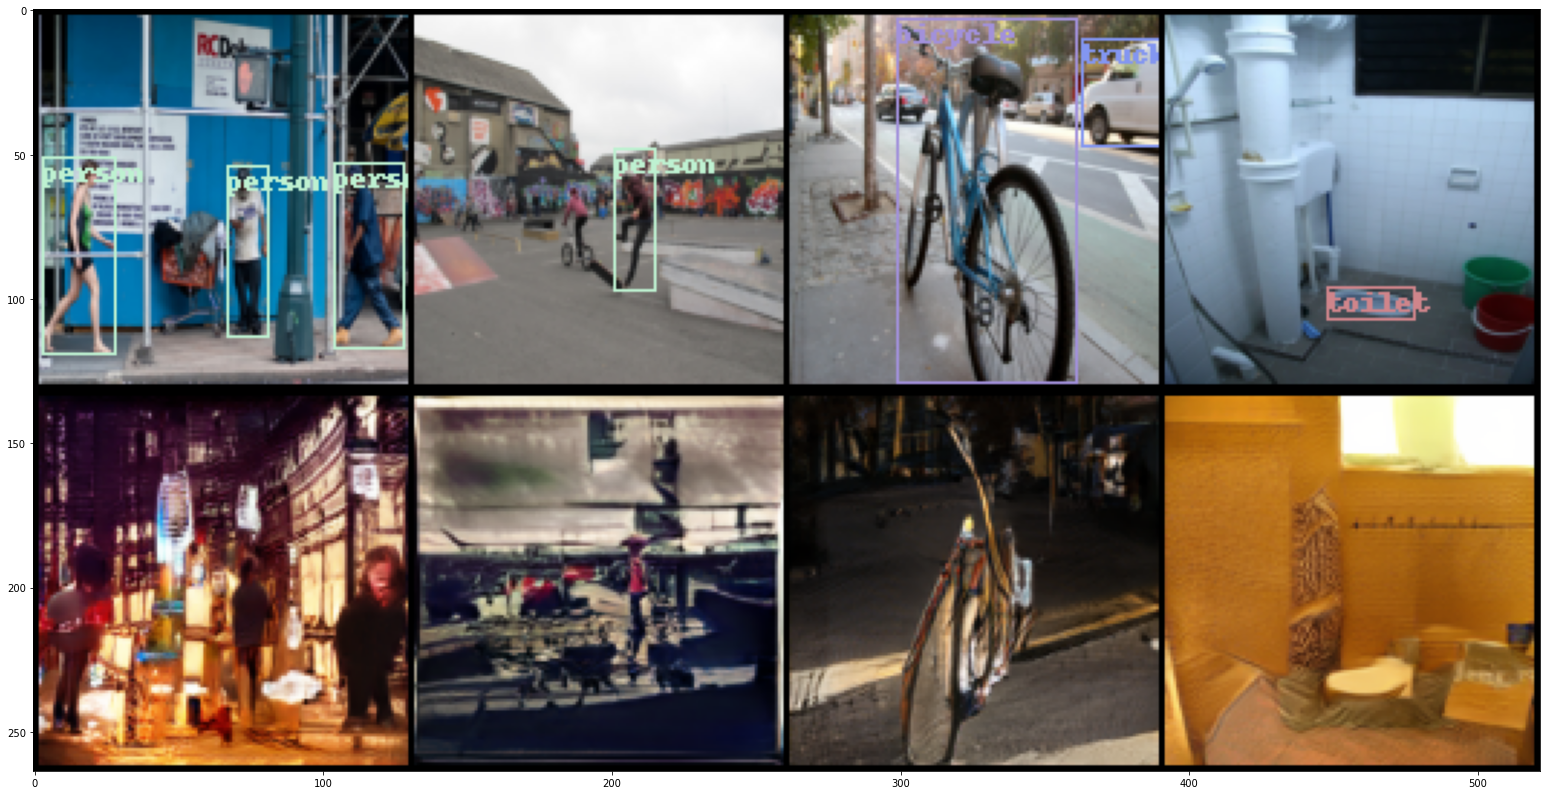

In [6]:
fake_images = ((fake_imgs.detach().cpu()*0.5 + 0.5)*255).to(torch.uint8)
real_images = ((real_imgs.detach().cpu()*0.5 + 0.5)*255).to(torch.uint8)
void_images = torch.zeros_like(fake_images, device="cpu")
# void_images = torch.full_like(fake_images, 255, device="cpu")

# vocab
with open("vocab.json", 'r') as f:
    vocab = json.load(f)

boxed_imgs = []
colors = torch.randint(128, 255, (num_classes, 3)).numpy()
bbbox = bbox * img_size
bbbox[:,:,2] += bbbox[:,:,0] # N*8*4
bbbox[:,:,3] += bbbox[:,:,1]

label_redlist = ["__image__","building-other", "bush", "cabinet", "cage", "cardboard", "carpet", "ceiling-other", "ceiling-tile", "cloth", "clothes", "clouds", "counter", "cupboard", "curtain", "desk-stuff", "dirt", "fence","floor-other", "floor-stone", "floor-tile", "floor-wood", "flower", "fog", "furniture-other", "grass", "gravel", "ground-other", "hill", "house", "leaves", "light", "mat", "metal", "mirror-stuff", "moss", "mountain", "mud", "napkin", "net", "paper", "pavement", "pillow", "plant-other", "plastic", "platform", "playingfield", "railing", "railroad", "river", "road", "rock", "roof", "rug", "salad", "sand", "sea", "shelf", "sky-other", "skyscraper", "snow", "solid-other", "stairs", "stone", "straw", "structural-other", "table", "tent", "textile-other", "towel", "tree", "vegetable", "wall-brick", "wall-concrete", "wall-other", "wall-panel", "wall-stone", "wall-tile", "wall-wood", "water-other", "waterdrops", "window-blind", "window-other", "wood", "other"]

for img, boxes, cat in zip(real_images, bbbox, label):
    color = [tuple(colors[c]) for c in cat]
    cat = [vocab[c] for c in cat]

    boxed_img = draw_bounding_boxes(img, boxes, cat, colors=color, label_redlist=label_redlist)
    boxed_imgs.append(boxed_img)

# print(list(torch.is_tensor(t) for t in boxed_imgs))
# print(type(boxed_imgs))
boxed_imgs = torch.stack(boxed_imgs, dim=0)
# print(boxed_imgs.shape)
box_grid = make_grid(boxed_imgs[:4].data)
fake_grid = make_grid(fake_images[:4].data)
# real_grid = make_grid(real_images[:4].data)
all_grid = torch.cat([box_grid, fake_grid], dim=1)

plt.figure(figsize=(27, 15))
plt.imshow(all_grid.permute(1,2,0).numpy())

In [7]:
## 2. Output cls logits for each objs
from scene_generation.bilinear import crop_bbox_batch

def unpack_batch(label, bbox):
    # label: (bs, num_o, 1)
    # bbox: (bs, num_o, 4)
    obj_to_img = []
    bbxs = []
    objs = []
    for idx,(l, bb) in enumerate(zip(label, bbox)):
        id = (l != 0).squeeze()
        obj_to_img.extend([idx]*len(torch.nonzero(l)))
        bbxs.append(bb[id])
        objs.append(l[id])

    bbxs = torch.cat(bbxs, dim=0)
    objs = torch.cat(objs, dim=0)
    obj_to_img = torch.tensor(obj_to_img)
    return objs, bbxs, obj_to_img

print(label.dtype)
print(bbox.dtype)
objs, bbxs, obj_to_img = unpack_batch(label, bbox)

with torch.no_grad():
    real_crops = crop_bbox_batch(real_imgs, bbxs, obj_to_img, 224)
    fake_crops = crop_bbox_batch(fake_imgs, bbxs, obj_to_img, 224)

print(real_crops.shape)
print(fake_crops.shape)

torch.int64
torch.float32
torch.Size([86, 3, 224, 224])
torch.Size([86, 3, 224, 224])
/root/scene_generation/scene_generation/bilinear.py:75: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (bbox_to_feats.data == i).nonzero()


In [8]:
import time
import csv
import numpy as np

@torch.no_grad()
def test_model(model, val_dataloader, input_shape=224, out_path=None):
    since = time.time()

    device = 'cuda'

    model.train(False)  # Set model to evaluate mode
    dataloader = val_dataloader

    running_corrects1 = 0
    running_corrects2 = 0
    objects_len = 0
    out_path1 = os.path.join(out_path, "logits_coco_128_val_gt.csv")
    out_path2 = os.path.join(out_path, "logits_coco_128_val_pred.csv")

    with open(out_path1, mode="w", encoding="utf-8", newline="") as csvfile1, open(out_path2, mode="w", encoding="utf-8", newline="") as csvfile2:
        writer1 = csv.writer(csvfile1)
        writer2 = csv.writer(csvfile2)
        columns = ['label'] + ['pred'] + ["logits"+str(i+1) for i in range(172)]
        writer1.writerow(columns)
        writer2.writerow(columns)
        
        # Iterate over data.
        for data in tqdm(dataloader, total=len(dataloader)):
        # for data in tqdm(dataloader, total=len(dataloader)):
            # get the inputs
            real_imgs, labels, bbox = data
            # print(labels.shape)
            # print(bbox.shape)
            bbox = bbox.float()
            labels, boxes, obj_to_img = unpack_batch(labels.unsqueeze(2), bbox)

            real_imgs = real_imgs.to(device)
            boxes = boxes.to(device)
            boxes[:,2]+=boxes[:,0]
            boxes[:,3]+=boxes[:,1]
            obj_to_img = obj_to_img.to(device)
            gt_label = labels.to(device)

            objects_len += boxes.shape[0]

            with torch.no_grad():
                real_crops = crop_bbox_batch(real_imgs, boxes, obj_to_img, input_shape)
                fake_crops = crop_bbox_batch(fake_imgs, boxes, obj_to_img, input_shape)

            # forward
            real_outputs = model(real_crops)
            if type(real_outputs) == tuple:
                real_outputs, _ = real_outputs
            real_outputs = F.softmax(real_outputs, dim=-1)
           
            _, preds = torch.max(real_outputs, 1)

            # statistics
            num_correct1 = torch.sum(preds.view(-1,1) == gt_label)
            running_corrects1 += num_correct1
            
            ## save logits
            labels = gt_label.detach().cpu().numpy().reshape(-1,1)
            real_outputs = real_outputs.detach().cpu().numpy()
            preds = preds.detach().cpu().numpy().reshape(-1,1)
            
            writer1.writerows(np.concatenate((labels,preds,real_outputs), axis=1).tolist())
            
            # forward
            fake_outputs = model(fake_crops)
            if type(fake_outputs) == tuple:
                fake_outputs, _ = fake_outputs
            fake_outputs = F.softmax(fake_outputs, dim=-1)
           
            _, preds = torch.max(fake_outputs, 1)

            # statistics
            num_correct2 = torch.sum(preds.view(-1,1) == gt_label)

            running_corrects2 += num_correct2
            
            # print((preds.view(-1,1) == gt_label).shape)
            # print("nc1:{}".format(num_correct1.item()))
            # print("nc2:{}".format(num_correct2.item()))
            # print(boxes.shape[0])
            
            ## save logits
            fake_outputs = fake_outputs.detach().cpu().numpy()
            preds = preds.detach().cpu().numpy().reshape(-1,1)
            
            # print(preds.shape)
            # print(labels.shape)
            
            writer2.writerows(np.concatenate((labels,preds,fake_outputs), axis=1).tolist())
            


    print(objects_len)
    epoch_acc = running_corrects1.item() / objects_len

    print('{} Acc: {:.4f}'.format("val_gt", epoch_acc))
    epoch_acc = running_corrects2.item() / objects_len

    print('{} Acc: {:.4f}'.format("val_pred", epoch_acc))

  
    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model


In [9]:
## prepare classifer
import torchvision
from test_accuracy_net import load_model

model_path = 'model/accuracy net/resnet101_172_classes_128_pixels_0.623.pth'

model_conv = load_model(model_path)

test_model(model_conv, dataloader, 224, out_path='outputs/test_obj_accuracy')



[Building resnet101]
100%|██████████| 387/387 [02:25<00:00,  2.65it/s]34370
val_gt Acc: 0.1352
val_pred Acc: 0.0068
Validation complete in 2m 26s



, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [10]:
torch.sum(preds == gt_label)


NameError: name 'preds' is not defined

In [23]:
## 2. Output logits of each object.
# print(real_imgs.device)
# print(bbox.device)
# print(label.device)

# d_out_real, d_out_robj, d_out_robj_app = netD(real_imgs, bbox, label)
# print(d_out_real.shape)
# # print(d_out_robj)
# l = label.view(-1)
# l = l[l!=0]
# for ll, logit in zip(l, d_out_robj.squeeze()):
#     print(ll.item(), logit.data.item())

torch.Size([8, 1])
1 -0.2612754702568054
1 0.03872084617614746
76 -0.18422667682170868
76 -0.19110488891601562
72 -0.25640249252319336
72 -0.27743396162986755
105 0.15725749731063843
165 0.22144003212451935
79 -0.5192597508430481
78 -0.22170838713645935
98 3.2801027297973633
107 -0.13186267018318176
118 0.5501559972763062
123 -0.1545582264661789
152 0.7337771654129028
172 1.9865986108779907
2 -0.18812449276447296
7 -0.5119970440864563
1 -0.4417340159416199
97 -0.23523539304733276
146 -0.2697247862815857
149 0.6393465399742126
157 3.133054256439209
169 0.21018990874290466
82 -0.5203137397766113
79 0.5187612175941467
98 0.4320351779460907
102 -0.4253304898738861
107 -0.5169228315353394
112 0.42926862835884094
117 0.2267388105392456
172 -0.2736133933067322
1 0.06955376267433167
50 -0.3308706283569336
78 -0.3729110062122345
79 1.6483190059661865
98 -0.49674850702285767
107 1.8106579780578613
172 0.004072099924087524
173 0.23857441544532776
82 0.4627058207988739
78 -0.5004295110702515
79 1.

In [22]:
# d_out_fake, d_out_fobj, d_out_fobj_app = netD(fake_imgs.detach(), bbox, label)
# for ll, logit in zip(l, d_out_fobj.squeeze()):
#     print(ll.item(), logit.item())

1 -0.3905864655971527
1 -1.6424726247787476
76 -0.19387602806091309
76 -0.22126121819019318
72 -0.2489301711320877
72 -0.2687270939350128
105 -0.5375497341156006
165 0.22125442326068878
79 -0.5187462568283081
78 -0.36633649468421936
98 -2.2823472023010254
107 -0.26703691482543945
118 0.5383370518684387
123 -0.16028960049152374
152 0.7330015897750854
172 -1.912430763244629
2 -0.1945435106754303
7 -0.42087358236312866
1 -0.4501712918281555
97 -0.18759769201278687
146 -0.47517839074134827
149 0.5847305059432983
157 -0.9225345849990845
169 0.19600412249565125
82 -0.5234420299530029
79 0.19383357465267181
98 -1.502249002456665
102 -0.3885912001132965
107 -0.5536972284317017
112 0.38695311546325684
117 -1.294775128364563
172 -0.3888015151023865
1 0.045007314532995224
50 -0.33180364966392517
78 -0.5167419910430908
79 -3.0289230346679688
98 -0.5049034953117371
107 0.6659475564956665
172 -0.2942357063293457
173 0.2255788892507553
82 -0.0012354552745819092
78 -0.5292998552322388
79 -0.5258802175

In [ ]:
for 